In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qutip import *

In [2]:
def Hamil( g, eta, Omega, theta , ge, a, Del_c ):
    # input: relevant parameters and operators
    # output: Hamiltonian operator

    H0 = Del_c * a.dag() * a + Del_c * ge.dag() * ge
    H1 = (a.dag() * ge + a * ge.dag()) 
    H2 = (a + a.dag())
    H3 = (np.exp(1j*theta) * ge + np.exp(-1j*theta) * ge.dag()) 

    H = H0 + g * H1 + eta * H2 + Omega * H3

    return H

def Liouv( H, C1, C2, C1dC1, C2dC2 ):
    # input: relevant operators and Hamiltonian
    # output: Liouvillian
    LH = -1j * (spre(H) - spost(H))
    L1 = spre(C1)*spost(C1.dag()) - 0.5*spre(C1dC1) - 0.5*spost(C1dC1)
    L2 = spre(C2)*spost(C2.dag()) - 0.5*spre(C2dC2) - 0.5*spost(C2dC2)

    L = LH+L1+L2
    return L 

def correlation_ss_gtt(H, tlist, c_ops, a_op, b_op, c_op, d_op, rho0=None):
    if rho0 == None:
        rho0 = steadystate(H, c_ops)

    return mesolve(H, d_op * rho0 * a_op, tlist, c_ops, [b_op * c_op]).expect[0]

In [3]:
## PARAMETERS ##
kappa = 20*2*np.pi      # cavity dissipation rate (GHz)
gamma = 2*np.pi         # atom dissipation rate (GHz)
N = 5                   # number of cavity fock states 
g  = 2*kappa            # QD-cavity coupling strength
eta = 0.1*kappa         # weak cavity coupling strength
Omega = 0.124*g

## OPERATORS ##
# Ladder operators
a  = tensor(destroy(N), qeye(2))    # a - cavity lowering operator
sm = tensor(qeye(N), sigmam())    # sigma - atomic lowering operator

# Collapse Operators
C1 = np.sqrt(kappa)*a
C2 = np.sqrt(gamma)*sm
C1dC1 = C1.dag() * C1
C2dC2 = C2.dag() * C2

## ARRAYS ##
num = np.linspace(-1.5,1.5,101)
Del_c_vec = num * g
theta_vec = num * np.pi
taulist = np.linspace(0,20,200)

In [4]:
## CALCULATION ##

g2_matrix = np.zeros((101,101))
i,j = [0,0]

for i in range(101):
    for j in range(101):
        H = Hamil( g, eta, Omega, theta_vec[i], sm, a, Del_c_vec[j] )
        L = Liouv( H, C1, C2, C1dC1, C2dC2 )
        rhoss = steady(L)

        n = np.trace(a.dag()*a*rhoss)
        G2 = np.trace(a.dag()*a.dag()*a*a*rhoss)
        g2 = G2/n**2

        g2_matrix[j,i] = g2
    

/var/folders/22/rhd5r89n6hjdb8xzbytwrmsw0000gn/T/ipykernel_42365/4032409719.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  g2_matrix[j,i] = g2


Text(0.5, 1.0, 'Plot of log10(g^(2))')

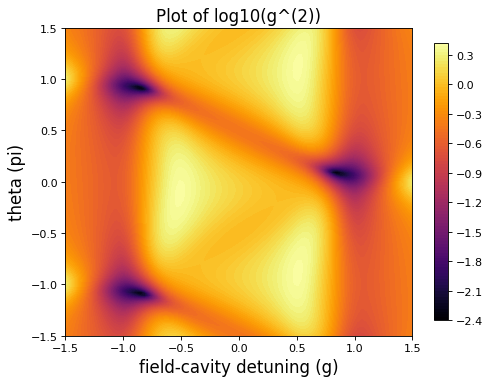

In [11]:
Y,X = np.meshgrid(num,num)

fig1, ax1 = plt.subplots(1, 1, figsize=(7,5), dpi=80)
cs = ax1.contourf(X,Y,np.log10(g2_matrix),100,cmap='inferno')
cbar = fig1.colorbar(cs,shrink=0.9)
ax1.set_xlabel('field-cavity detuning (g)',fontsize=15)
ax1.set_ylabel('theta (pi)',fontsize=15)
ax1.set_title('Plot of log10(g^(2))',fontsize=15)